In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from subprocess import call
from IPython.display import Image
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from imblearn.ensemble import BalanceCascade
from sklearn.metrics import precision_recall_curve
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import GridSearchCV

In [3]:
def dtype_compressor(df):
  #object 
  # when unique ratio > 0.5, catogory stands less memory than object
  converted_obj = pd.DataFrame()
  df_obj = df.select_dtypes(include=['object'])
  for col in df_obj.columns:
    converted_obj.loc[:,col] = df_obj.loc[:,col].astype('category')

  # numbers
  df_down_num = pd.DataFrame()
  df_num = df.select_dtypes(include=['number'])
  for col in df_num.columns:
    df_down_num.loc[:,col] = pd.to_numeric(df_num.loc[:,col],downcast='signed')

  # merge
  df = pd.concat([converted_obj,df_down_num],axis=1)
  
  del converted_obj, df_obj, df_down_num, df_num  
  
  return df

In [4]:
def fast_datetime(s):
    dates = {date:pd.to_datetime(date,format='%Y-%m-%d') for date in s.unique()}
    return s.map(dates)

In [5]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

---

### 讀取並觀察資料

In [6]:
KKboxTrainMembersTransac = pd.read_csv('KKboxTrainMembersTransac.csv')

In [7]:
KKboxTrainMembersTransac.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,last_last_churn,last_auto_renew,is_discount,amount_per_day,longtime_user
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1,18,36,0,9,2005-04-06,1,0,2,2.48,0
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,10,38,1,9,2005-04-07,0,1,23,4.99,1
2,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,10,38,1,9,2005-04-07,0,1,23,4.99,1
3,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1,11,27,0,9,2005-10-16,0,1,10,4.97,0
4,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1,13,23,0,9,2005-11-02,1,0,3,3.11,0


In [8]:
KKboxTrainMembersTransac = dtype_compressor(KKboxTrainMembersTransac)

In [9]:
d = ['registration_init_time']
for col in d:
  KKboxTrainMembersTransac[col] = fast_datetime(KKboxTrainMembersTransac[col])

In [10]:
# 針對名目特徵(無序類別)做one-hot encoding，並減少一維度作為減少特徵間高相關性處理
ToDummiesCol = ['city', 'gender', 'registered_via', 'last_last_churn',\
                 'last_auto_renew', 'longtime_user']
KKboxTrainMembersTransac = pd.get_dummies(KKboxTrainMembersTransac, prefix_sep="__", columns=ToDummiesCol, drop_first=True)

In [11]:
KKboxTrainMembersTransac.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767924 entries, 0 to 767923
Data columns (total 35 columns):
msno                      767924 non-null category
registration_init_time    767924 non-null datetime64[ns]
is_churn                  767924 non-null int8
bd                        767924 non-null int8
is_discount               767924 non-null int16
amount_per_day            767924 non-null float64
city__3                   767924 non-null uint8
city__4                   767924 non-null uint8
city__5                   767924 non-null uint8
city__6                   767924 non-null uint8
city__7                   767924 non-null uint8
city__8                   767924 non-null uint8
city__9                   767924 non-null uint8
city__10                  767924 non-null uint8
city__11                  767924 non-null uint8
city__12                  767924 non-null uint8
city__13                  767924 non-null uint8
city__14                  767924 non-null uint8
city__15     

In [12]:
KKboxTrainMembersTransac.describe()

,is_churn,bd,is_discount,amount_per_day,city__3,city__4,city__5,city__6,city__7,city__8,...,city__22,gender__0,gender__1,registered_via__4,registered_via__7,registered_via__9,registered_via__13,last_last_churn__1,last_auto_renew__1,longtime_user__1
count,767924.00,767924.00,767924.00,767924.00,767924.00,767924.00,767924.00,767924.00,767924.00,767924.00,...,767924.00,767924.00,767924.00,767924.00,767924.00,767924.00,767924.00,767924.00,767924.00,767924.00
mean,0.10,29.96,18.68,4.81,0.01,0.11,0.16,0.06,0.01,0.02,...,0.10,0.46,0.52,0.07,0.19,0.52,0.00,0.01,0.78,0.44
std,0.30,8.89,8.38,0.59,0.11,0.31,0.37,0.24,0.08,0.13,...,0.30,0.50,0.50,0.25,0.39,0.50,0.03,0.10,0.41,0.50
min,0.00,13.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,24.00,12.00,4.77,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
50%,0.00,28.00,21.00,4.94,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00
75%,0.00,34.00,26.00,4.97,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00
max,1.00,99.00,244.00,7.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


---

##### 拆分訓練集與測試集

In [13]:
X = KKboxTrainMembersTransac.iloc[:,3:]
y = KKboxTrainMembersTransac.iloc[:,2]

In [14]:
# from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=87)

##### 訓練模型

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
RandomForestClf = RandomForestClassifier(random_state=87, n_estimators=100, criterion='gini', max_depth=30, min_samples_leaf=2, min_samples_split=2, max_features='auto')

In [17]:
RandomForestClf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=87, verbose=0, warm_start=False)

In [18]:
# 驗證模型準確度
RandomForestClf.score(X=X_train, y=y_train)

0.9338270585215033

##### 預測

In [19]:
y_pred_RandomForestClf = RandomForestClf.predict(X_test)

##### AUC

In [20]:
auc_RandomForestClf = roc_auc_score(y_test, y_pred_RandomForestClf)
print('AUC: %.3f' % auc_RandomForestClf)

AUC: 0.657


##### 驗證

              precision    recall  f1-score   support

           0       0.93      0.99      0.96    206774
           1       0.72      0.33      0.45     23604

   micro avg       0.92      0.92      0.92    230378
   macro avg       0.82      0.66      0.70    230378
weighted avg       0.91      0.92      0.90    230378



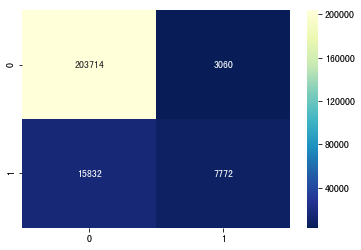

In [21]:
print(metrics.classification_report(y_test, y_pred_RandomForestClf))
cm = metrics.confusion_matrix(y_test, y_pred_RandomForestClf)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt="d")
plt.show()

##### 小結：
* 數據不平衡造成模型對於流失(is_churn=1)容易有偏誤(視為噪音等)，故還是需要數據平衡化的資料集進行跑模型

---

### 使用模型class_weight參數調整類別懲罰比例—balanced

In [22]:
RandomForestClfClassWeightBalanced = RandomForestClassifier(random_state=87, n_estimators=100, criterion='gini', max_depth=30, min_samples_leaf=2, min_samples_split=2, max_features='auto', class_weight='balanced')

In [23]:
RandomForestClfClassWeightBalanced.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=30, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=87, verbose=0, warm_start=False)

In [24]:
# Accuracy準確度
RandomForestClfClassWeightBalanced.score(X=X_train, y=y_train)

0.9284786790339804

In [25]:
# 預測
y_pred_RandomForestClfClassWeightBalanced = RandomForestClfClassWeightBalanced.predict(X_test)

In [26]:
# AUC
auc_RandomForestClfClassWeightBalanced = roc_auc_score(y_test, y_pred_RandomForestClfClassWeightBalanced)
print('AUC: %.3f' % auc_RandomForestClfClassWeightBalanced)

AUC: 0.733


              precision    recall  f1-score   support

           0       0.95      0.92      0.93    206774
           1       0.44      0.55      0.49     23604

   micro avg       0.88      0.88      0.88    230378
   macro avg       0.69      0.73      0.71    230378
weighted avg       0.89      0.88      0.89    230378



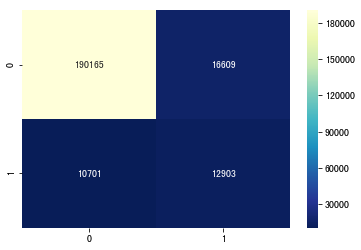

In [27]:
# 驗證
print(metrics.classification_report(y_test, y_pred_RandomForestClfClassWeightBalanced))
cm = metrics.confusion_matrix(y_test, y_pred_RandomForestClfClassWeightBalanced)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt="d")
plt.show()

---

### 使用模型class_weight參數調整類別懲罰比例

In [28]:
class_weight_threshold = [{0:0.5, 1:0.5}, {0:0.4, 1:0.6}, {0:0.3, 1:0.7}, \
                          {0:0.2, 1:0.8}, {0:0.15, 1:0.85}, {0:0.1, 1:0.9}]

--------------------------------------------------
class_weight比例:{0: 0.5, 1: 0.5}
Accuracy: 0.93
AUC: 0.657
              precision    recall  f1-score   support

           0       0.93      0.99      0.96    206774
           1       0.72      0.33      0.45     23604

   micro avg       0.92      0.92      0.92    230378
   macro avg       0.82      0.66      0.70    230378
weighted avg       0.91      0.92      0.90    230378



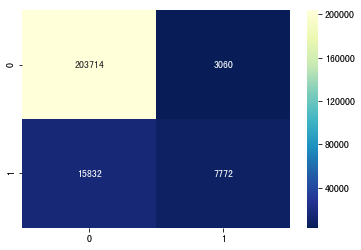

--------------------------------------------------
class_weight比例:{0: 0.4, 1: 0.6}
Accuracy: 0.94
AUC: 0.672
              precision    recall  f1-score   support

           0       0.93      0.98      0.95    206774
           1       0.67      0.36      0.47     23604

   micro avg       0.92      0.92      0.92    230378
   macro avg       0.80      0.67      0.71    230378
weighted avg       0.90      0.92      0.91    230378



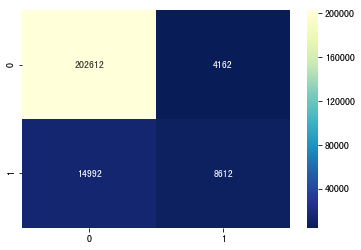

--------------------------------------------------
class_weight比例:{0: 0.3, 1: 0.7}
Accuracy: 0.94
AUC: 0.688
              precision    recall  f1-score   support

           0       0.93      0.97      0.95    206774
           1       0.62      0.41      0.49     23604

   micro avg       0.91      0.91      0.91    230378
   macro avg       0.78      0.69      0.72    230378
weighted avg       0.90      0.91      0.91    230378



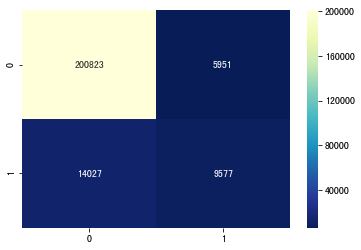

--------------------------------------------------
class_weight比例:{0: 0.2, 1: 0.8}
Accuracy: 0.94
AUC: 0.707
              precision    recall  f1-score   support

           0       0.94      0.95      0.95    206774
           1       0.53      0.46      0.49     23604

   micro avg       0.90      0.90      0.90    230378
   macro avg       0.74      0.71      0.72    230378
weighted avg       0.90      0.90      0.90    230378



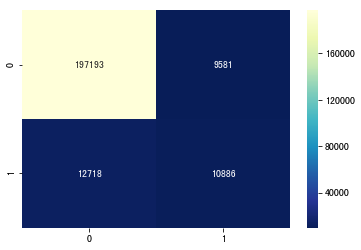

--------------------------------------------------
class_weight比例:{0: 0.15, 1: 0.85}
Accuracy: 0.94
AUC: 0.720
              precision    recall  f1-score   support

           0       0.94      0.94      0.94    206774
           1       0.49      0.50      0.49     23604

   micro avg       0.89      0.89      0.89    230378
   macro avg       0.71      0.72      0.72    230378
weighted avg       0.90      0.89      0.90    230378



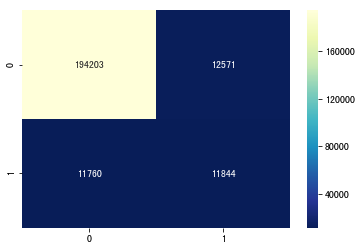

--------------------------------------------------
class_weight比例:{0: 0.1, 1: 0.9}
Accuracy: 0.93
AUC: 0.735
              precision    recall  f1-score   support

           0       0.95      0.92      0.93    206774
           1       0.43      0.55      0.49     23604

   micro avg       0.88      0.88      0.88    230378
   macro avg       0.69      0.73      0.71    230378
weighted avg       0.89      0.88      0.89    230378



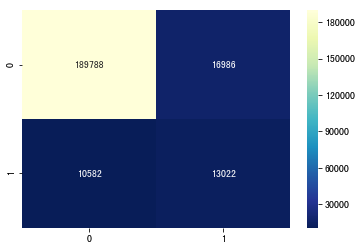

In [29]:
for i in class_weight_threshold:
    RandomForestClfClassWeight = RandomForestClassifier(random_state=87, n_estimators=100, criterion='gini', max_depth=30, min_samples_leaf=2, min_samples_split=2, max_features='auto', class_weight=i)
    RandomForestClfClassWeight.fit(X_train, y_train)
    AccuracyOfRandomForestClfClassWeight = RandomForestClfClassWeight.score(X=X_train, y=y_train)
    print('-'*50)
    print('class_weight比例:{}'.format(i))
    print('Accuracy: {:.2f}'.format(AccuracyOfRandomForestClfClassWeight))
    y_pred_RandomForestClfClassWeight = RandomForestClfClassWeight.predict(X_test)
    # AUC
    auc_RandomForestClfClassWeight = roc_auc_score(y_test, y_pred_RandomForestClfClassWeight)
    print('AUC: %.3f' % auc_RandomForestClfClassWeight)
    # Report
    print(metrics.classification_report(y_test, y_pred_RandomForestClfClassWeight))
    cm = metrics.confusion_matrix(y_test, y_pred_RandomForestClfClassWeight)
    sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt="d")
    plt.show()

##### 小結：
* 調整class_weight主要是針對給予少量樣本(is_churn=1)更多的懲罰(penalty)，此為解決數據不平衡問題的標準方法之一。
* 根據使用不同懲罰比例，流失(is_churn=1)懲罰越高，Recall(召回率)越好，但即使懲罰比例達到了9成，整體模型仍呈現不是很好的結果。
* 依照不同class_weight參數調整，'balanced'與懲罰比例90%:10%結果最相近，但懲罰比85%:15%目前效果最佳(Precision與Recall皆約50%)。

---

### 解決數據不平衡問題(使用Oversampling -> Smote)

In [30]:
over_samples = SMOTE(random_state=1234)

In [31]:
over_samples_X,over_samples_y = over_samples.fit_sample(X_train, y_train)

In [32]:
# 重抽樣前的類別比例
print(y_train.value_counts()/len(y_train))
# 重抽樣後的類別比例
print(pd.Series(over_samples_y).value_counts()/len(over_samples_y))

0   0.90
1   0.10
Name: is_churn, dtype: float64
1   0.50
0   0.50
dtype: float64


In [33]:
# 使用PCA降特徵維度
# pca = PCA(n_components=2)

In [34]:
# over_samples_X_pca = pca.fit_transform(over_samples_X)
# X_test_pca = pca.fit_transform(X_test)

In [35]:
# 訓練模型
RandomForestClfSmote = RandomForestClassifier(random_state=87, n_estimators=100, criterion='gini', max_depth=30, min_samples_leaf=2, min_samples_split=2, max_features='auto')
RandomForestClfSmote.fit(over_samples_X, over_samples_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=87, verbose=0, warm_start=False)

In [36]:
# Accuracy準確度
RandomForestClfSmote.score(X=over_samples_X, y=over_samples_y)

0.9376389858926081

In [37]:
# 預測
y_pred_RandomForestClfSmote = RandomForestClfSmote.predict(X_test)

In [38]:
# AUC
auc_RandomForestClfSmote = roc_auc_score(y_test, y_pred_RandomForestClfSmote)
print('AUC: %.3f' % auc_RandomForestClfSmote)

AUC: 0.725


              precision    recall  f1-score   support

           0       0.94      0.93      0.94    206774
           1       0.46      0.52      0.49     23604

   micro avg       0.89      0.89      0.89    230378
   macro avg       0.70      0.73      0.71    230378
weighted avg       0.89      0.89      0.89    230378



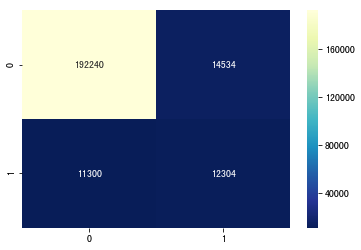

In [39]:
# 驗證
print(metrics.classification_report(y_test, y_pred_RandomForestClfSmote))
cm = metrics.confusion_matrix(y_test, y_pred_RandomForestClfSmote)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt="d")
plt.show()

##### Feature importance(特徵重要性)

Variable: last_auto_renew__1   Importance: 0.21
Variable: amount_per_day       Importance: 0.2
Variable: is_discount          Importance: 0.19
Variable: bd                   Importance: 0.08
Variable: longtime_user__1     Importance: 0.05
Variable: registered_via__9    Importance: 0.04
Variable: registered_via__7    Importance: 0.03
Variable: last_last_churn__1   Importance: 0.03
Variable: city__13             Importance: 0.02
Variable: registered_via__4    Importance: 0.02
Variable: city__4              Importance: 0.01
Variable: city__5              Importance: 0.01
Variable: city__6              Importance: 0.01
Variable: city__14             Importance: 0.01
Variable: city__15             Importance: 0.01
Variable: city__22             Importance: 0.01
Variable: gender__0            Importance: 0.01
Variable: gender__1            Importance: 0.01
Variable: city__3              Importance: 0.0
Variable: city__7              Importance: 0.0
Variable: city__8              Importance: 

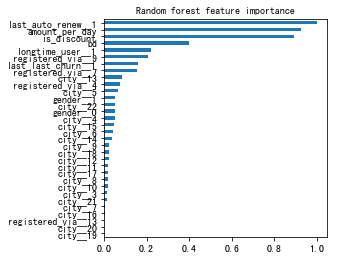

In [40]:
feature_list = list(X_train.columns)

# Get numerical feature importances
importances = list(RandomForestClfSmote.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(X_train, round(importance, 2)) for X_train, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

# 畫barplot
fi = pd.concat([pd.DataFrame(KKboxTrainMembersTransac.columns[3:], columns = ['feature']), pd.DataFrame({'fscore':RandomForestClfSmote.feature_importances_})], axis=1, sort=False)
fi['fscore'] = fi['fscore'] / fi['fscore'].max()
fi.sort_values('fscore', ascending = True, inplace = True)
fi.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(4, 4))
plt.title('Random forest feature importance', fontsize = 10)
plt.xlabel('')
plt.ylabel('')
plt.show()

##### 小結：
* 使用Smote(Oversampling)比調整class_weight懲罰比例要好點(Recall, F-score較好)，但對於正樣本(is_churn=1)預測仍有很大優化空間。

---

### 解決數據不平衡問題(使用Undersampling -> Tomek Links)

##### Tomek Links定義
* 相反類別中相鄰最近的兩點稱為Tomek Links對，表示這對Tomek Links中有一點如果不是噪音，就是位於類別交界處，可進行數據清洗掉這個多餘的點

##### 一般使用Tomek Links有兩種用途:
* Undersampling
* 數據清洗:將Tomek Links對中的兩個樣本刪除

In [41]:
# 將訓練集做Tomek Links(Undersampling)
tl = TomekLinks()
X_train_tl, y_train_tl = tl.fit_resample(X_train, y_train)

In [42]:
RandomForestClfTomekLinks = RandomForestClassifier(random_state=87, n_estimators=100, criterion='gini', max_depth=30, min_samples_leaf=2, min_samples_split=2, max_features='auto')

In [43]:
RandomForestClfTomekLinks.fit(X_train_tl, y_train_tl)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=87, verbose=0, warm_start=False)

In [44]:
# Accuracy
RandomForestClfTomekLinks.score(X=X_train_tl, y=y_train_tl)

0.9352160216866474

In [45]:
# 預測
y_pred_RandomForestClfTomekLinks = RandomForestClfTomekLinks.predict(X_test)

In [46]:
# AUC
auc_RandomForestClfTomekLinks = roc_auc_score(y_test, y_pred_RandomForestClfTomekLinks)
print('AUC: %.3f' % auc_RandomForestClfTomekLinks)

AUC: 0.665


              precision    recall  f1-score   support

           0       0.93      0.98      0.96    206774
           1       0.70      0.35      0.46     23604

   micro avg       0.92      0.92      0.92    230378
   macro avg       0.81      0.66      0.71    230378
weighted avg       0.91      0.92      0.91    230378



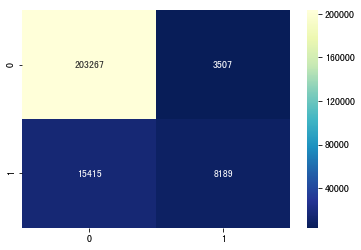

In [47]:
# 驗證
print(metrics.classification_report(y_test, y_pred_RandomForestClfTomekLinks))
cm = metrics.confusion_matrix(y_test, y_pred_RandomForestClfTomekLinks)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt="d")
plt.show()

##### 小結：
* 使用Tomek Links(Undersampling)結果較Raw Data未做任何處理稍微好點，但似乎也不算太好，來嘗試Smote+Tomek Links吧!

---

### 解決數據不平衡問題(使用Smote+Tomek Links)

In [48]:
tl = TomekLinks()
X_train_smote_tl, y_train_smote_tl = tl.fit_resample(over_samples_X, over_samples_y)

In [49]:
RandomForestClfSmoteTomekLinks = RandomForestClassifier(random_state=87, n_estimators=100, criterion='gini', max_depth=30, min_samples_leaf=2, min_samples_split=2, max_features='auto')

In [50]:
RandomForestClfSmoteTomekLinks.fit(X_train_smote_tl, y_train_smote_tl)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=87, verbose=0, warm_start=False)

In [51]:
# Accuracyy
RandomForestClfSmoteTomekLinks.score(X=X_train_smote_tl, y=y_train_smote_tl)

0.9376929667419581

In [52]:
# 預測
y_pred_RandomForestClfSmoteTomekLinks = RandomForestClfSmoteTomekLinks.predict(X_test)

In [53]:
# AUC
auc_RandomForestClfSmoteTomekLinks = roc_auc_score(y_test, y_pred_RandomForestClfSmoteTomekLinks)
print('AUC: %.3f' % auc_RandomForestClfSmoteTomekLinks)

AUC: 0.726


              precision    recall  f1-score   support

           0       0.94      0.93      0.94    206774
           1       0.46      0.52      0.49     23604

   micro avg       0.89      0.89      0.89    230378
   macro avg       0.70      0.73      0.71    230378
weighted avg       0.89      0.89      0.89    230378



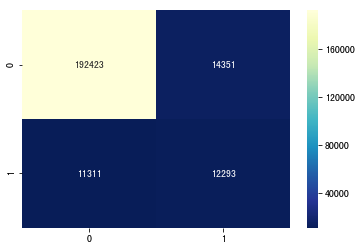

In [54]:
# 驗證
print(metrics.classification_report(y_test, y_pred_RandomForestClfSmoteTomekLinks))
cm = metrics.confusion_matrix(y_test, y_pred_RandomForestClfSmoteTomekLinks)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt="d")
plt.show()

##### 小結：
* Smote+Tomek Links比較Smote並無太多優化。

---

### 解決數據不平衡問題(使用Undersampling -> NearMiss)

##### Near Miss
* 根據查詢Near Miss定義，是一種KNN方式，將多數樣本(is_churn=0)選擇與最近的3個少數樣本(is_churn=1)的平均距離最小的樣本，整體是做Undersampling。

In [55]:
nr = NearMiss()
X_train_nr, y_train_nr = nr.fit_sample(X_train, y_train)

In [56]:
# 訓練模型
RandomForestClfNr = RandomForestClassifier(random_state=87, n_estimators=100, criterion='gini', max_depth=30, min_samples_leaf=2, min_samples_split=2, max_features='auto')
RandomForestClfNr.fit(X_train_nr, y_train_nr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=87, verbose=0, warm_start=False)

In [57]:
# Accuracy
RandomForestClfNr.score(X=X_train_nr, y=y_train_nr)

0.9509839550814966

In [58]:
# 預測
y_pred_RandomForestClfNr = RandomForestClfNr.predict(X_test)

In [59]:
# AUC
auc_RandomForestClfNr = roc_auc_score(y_test, y_pred_RandomForestClfNr)
print('AUC: %.3f' % auc_RandomForestClfNr)

AUC: 0.581


              precision    recall  f1-score   support

           0       0.97      0.22      0.35    206774
           1       0.12      0.95      0.21     23604

   micro avg       0.29      0.29      0.29    230378
   macro avg       0.55      0.58      0.28    230378
weighted avg       0.88      0.29      0.34    230378



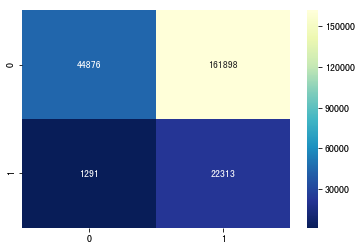

In [60]:
# 驗證
print(metrics.classification_report(y_test, y_pred_RandomForestClfNr))
cm = metrics.confusion_matrix(y_test, y_pred_RandomForestClfNr)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt="d")
plt.show()

##### 小結：
* 使用NearMiss，正樣本(is_churn=1)的precision明顯下降很多，但Recall特別好。不然就將smote+NearMiss試看看吧!

---

### 解決數據不平衡問題(使用Smote+Near Miss)

In [61]:
X_train_smote_nr, y_train_smote_nr = nr.fit_sample(over_samples_X, over_samples_y)

In [62]:
# 訓練模型
RandomForestClfSmoteNr = RandomForestClassifier(random_state=87, n_estimators=100, criterion='gini', max_depth=30, min_samples_leaf=2, min_samples_split=2, max_features='auto')
RandomForestClfSmoteNr.fit(X_train_smote_nr, y_train_smote_nr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=87, verbose=0, warm_start=False)

In [63]:
# Accuracy
RandomForestClfSmoteNr.score(X=X_train_smote_nr, y=y_train_smote_nr)

0.9369291604578529

In [64]:
# 預測
y_pred_RandomForestClfSmoteNr = RandomForestClfSmoteNr.predict(X_test)

In [67]:
# AUC
auc_RandomForestClfSmoteNr = roc_auc_score(y_test, y_pred_RandomForestClfSmoteNr)
print('AUC: %.3f' % auc_RandomForestClfSmoteNr)

AUC: 0.726


              precision    recall  f1-score   support

           0       0.94      0.93      0.94    206774
           1       0.46      0.52      0.49     23604

   micro avg       0.89      0.89      0.89    230378
   macro avg       0.70      0.73      0.71    230378
weighted avg       0.89      0.89      0.89    230378



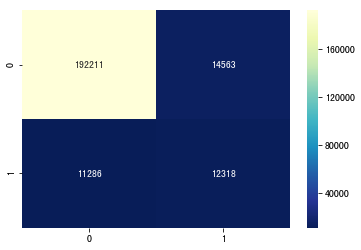

In [66]:
# 驗證
print(metrics.classification_report(y_test, y_pred_RandomForestClfSmoteNr))
cm = metrics.confusion_matrix(y_test, y_pred_RandomForestClfSmoteNr)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt="d")
plt.show()

##### 小結：
* 使用Near Miss(Undersampling)並沒有比Smote或Tomek Links好

---

### 下列針對RandomForestClassifier模型進行調參，確認相對最佳參數值

##### 使用GridSearchCV進行RandomForestClassifier模型參數調整，並使用smote後的訓練集進行模型訓練

In [68]:
parameters = {
    'n_estimators'      : [100],
    'max_depth'         : [30],
    'random_state'      : [87],
    'min_samples_split' : [2, 4, 8],
    'min_samples_leaf'  : [2, 4, 8]
}

In [69]:
clf = GridSearchCV(RandomForestClassifier(), parameters, cv=3, n_jobs=-1)

In [70]:
clf.fit(over_samples_X, over_samples_y)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [100], 'max_depth': [30], 'random_state': [87], 'min_samples_split': [2, 4, 8], 'min_samples_leaf': [2, 4, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [71]:
print(clf.score(X=over_samples_X, y=over_samples_y))
print(clf.best_params_)

0.9376389858926081
{'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 87}
